In [1]:
import torchvision
from poolDatasetV2 import PoolDatasetV2
import os
import torch
from torchvision.transforms import v2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [107]:
import matplotlib.pyplot as plt
import cv2

def show_image_with_box(image,boxes):

    image_draw = image.permute(1,2,0).clone().cpu().numpy()
    boxes_np = [box.tolist() for box in boxes]
    for box in boxes_np:
        x1, y1, x2, y2 = box
        cv2.rectangle(image_draw, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)
    
    plt.imshow(image_draw)
    plt.axis('off')
    plt.show()

In [2]:
transforms = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    #v2.RandomHorizontalFlip(p=1),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ROOT_DIR = os.getcwd() + "\\dataset\\images"

In [3]:
ds = PoolDatasetV2(ROOT_DIR,transforms)

In [4]:
train, test = ds.split_Data(0.9972)
len(train)

20

In [5]:
train[1]

(tensor([[[0.1922, 0.1804, 0.1765,  ..., 0.4706, 0.4314, 0.4431],
          [0.1725, 0.1686, 0.1608,  ..., 0.4980, 0.5961, 0.5490],
          [0.1686, 0.1529, 0.1725,  ..., 0.6863, 0.7137, 0.5961],
          ...,
          [0.2510, 0.2627, 0.2196,  ..., 0.1490, 0.1608, 0.1765],
          [0.2510, 0.2706, 0.2078,  ..., 0.1608, 0.1569, 0.1490],
          [0.2392, 0.2392, 0.2235,  ..., 0.1882, 0.1451, 0.1294]],
 
         [[0.2078, 0.1961, 0.1961,  ..., 0.4471, 0.4118, 0.4431],
          [0.2078, 0.1961, 0.1843,  ..., 0.4863, 0.5765, 0.5451],
          [0.2118, 0.1922, 0.2039,  ..., 0.6824, 0.6980, 0.5843],
          ...,
          [0.3137, 0.3137, 0.2627,  ..., 0.2039, 0.2196, 0.2392],
          [0.3098, 0.3059, 0.2392,  ..., 0.2157, 0.2078, 0.2118],
          [0.2863, 0.2784, 0.2667,  ..., 0.2627, 0.2000, 0.1843]],
 
         [[0.1804, 0.1725, 0.1765,  ..., 0.3686, 0.3255, 0.3608],
          [0.1765, 0.1725, 0.1647,  ..., 0.4118, 0.5255, 0.4784],
          [0.1804, 0.1647, 0.1843,  ...,

In [38]:
# def collate_fn(batch):
#     images = [item[0] for item in batch]
#     boxes = [item[1] for item in batch]

#     max_size_labels = max([len(box) for box in boxes])

#     for box in boxes:
#         if len(box) < max_size_labels:
#             toadd = torch.Tensor([0.0, 0.0, 0.0, 0.0])
#             box.extend([toadd for i in range(max_size_labels - len(box))])

#     return images, boxes

def collate_fn(batch):
    return batch

In [53]:
train_loader = DataLoader(train, batch_size=2, shuffle=True, collate_fn=collate_fn, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(train, batch_size=2, shuffle=True, collate_fn=collate_fn, pin_memory=True if torch.cuda.is_available() else False)

#### Model

In [54]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\romul\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Remove the 2 last layers

In [55]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

In [57]:
model.to(device)
for epoch in range(num_epochs):
    epoch_loss = 0
    for data in train_loader:
        # print(data)
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ['boxes'] = d[1]['boxes'].to(device)
            targ['labels'] = d[1]['labels'].to(torch.int64).to(device)
            targets.append(targ)

        loss_dict = model(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch}, Loss: {epoch_loss}')

Epoch: 0, Loss: 3.877807166427374
Epoch: 1, Loss: 2.4022593423724174
Epoch: 2, Loss: 1.6014178320765495
Epoch: 3, Loss: 1.4260650491341949
Epoch: 4, Loss: 1.569076593965292


In [108]:
model.eval()
data = next(iter(test_loader))

In [109]:
img = data[1][0]
boxes = data[0][1]['boxes']
labels = data[0][1]['labels']

In [110]:
output = model([img.to(device)])

In [111]:
output

[{'boxes': tensor([[164.6291, 187.7989, 186.4462, 205.2699],
          [160.7789, 152.6237, 188.9227, 169.1438],
          [166.5458, 192.1695, 188.2782, 201.5484],
          [164.9509, 152.3561, 177.4236, 168.6579],
          [173.6655, 189.4361, 186.4860, 202.9427],
          [164.5688, 193.8046, 181.9396, 204.1377],
          [175.9039, 154.6155, 187.2236, 167.4150],
          [177.5301, 191.7328, 187.9643, 201.8587]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1]),
  'scores': tensor([0.9404, 0.9401, 0.2627, 0.2592, 0.2024, 0.1367, 0.1210, 0.0553],
         grad_fn=<IndexBackward0>)}]

In [112]:
out_bbox = output[0]['boxes']
out_labels = output[0]['labels']
out_scores = output[0]['scores']

In [113]:
idx = [i for i in range(len(out_scores)) if out_scores[i] > 0.9]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


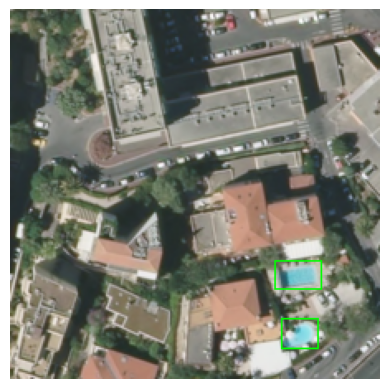

In [114]:
boxes =  []
for i in idx:
    boxes.append(out_bbox[i])

show_image_with_box(img, boxes)